# Fine-tuning a pretrained RoBERTa model for Sentiment Analysis

The following is a common task in which we aim to predict a product score (between 1 to 5) only from text reviews. This can be helpful when a company plans to introduce a new product to the market and obtains trial reviews to estimate its success.

For the task, I have used the Amazon All_Beauty review data published in 2023, which can be downloaded [here](https://amazon-reviews-2023.github.io/).
There is far more data available on other Amazon product sections, but this is just to show how sentiment analysis can be done in principle.

This notebook is structured as follows:

1. Data exploration: Here, I check for the target distribution and clean the data from NaNs/empty reviews
2. Data Preparation: (Stratified) splitting into train/validation/test datasets + taking care of differing sequence lengths
3. Dataset and Dataloading: Setting up of PyTorch dataset and dataloader. 
4. Training (Fine-tuning): Fine-tuning of a pretrained LLM with a) a large external data corpus and b) on the internal data
5. Testing (+ evaluation per target class): Evaluation on the test set, as well as Precision & Recall outcomes on each class
6. Visualization of Feature Importance: Gradient based visualization of which words were most important for prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.cuda.amp import GradScaler, autocast
import wandb
from tqdm import tqdm
from typing import List, Dict, Any, Tuple
sns.set_theme()

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\s_gue\anaconda3\envs\ml_basics\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Ensure reproducibility
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

## 1. Data Exploration

In [6]:
data = pd.read_json("../datasets/Amazon_Beauty/All_Beauty.jsonl", lines=True)

In [7]:
data.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True


#### Target Distribution

The first thing we can note is that we are dealing with a high class imbalance. Typical ways to tackle this issue include:
- Random under-sampling of majority class
- Random over-sampling of minority class
- Data augmentation
- Passing class weights to Optimizer

However, in this case we will ensure that the target distribution is similar across data splits. Thus, dealing with the imbalance in the training set would lead to a distribution shift during prediction.
Therefore, we will leave it like that for now.

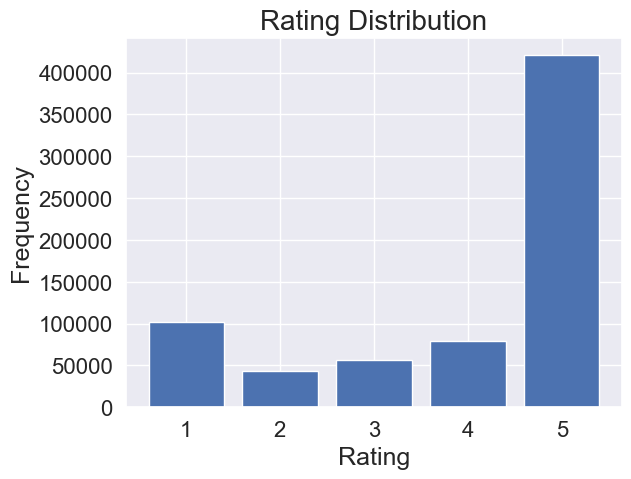

In [8]:
ax = data.rating.plot.hist(bins=5, rwidth=0.8, title="Rating Distribution", xticks=[1,2,3,4,5])
ax.title.set_size(20)
bin_edges = ax.patches[0].get_x()
bin_width = ax.patches[1].get_x() - ax.patches[0].get_x()
ax.set_xlabel('Rating', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
plt.xticks([bin_edges + i * bin_width + bin_width*0.8/2 for i in range(5)], range(1, 6), fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Additionally, we can see that the majority of products received less than 10 reviews.

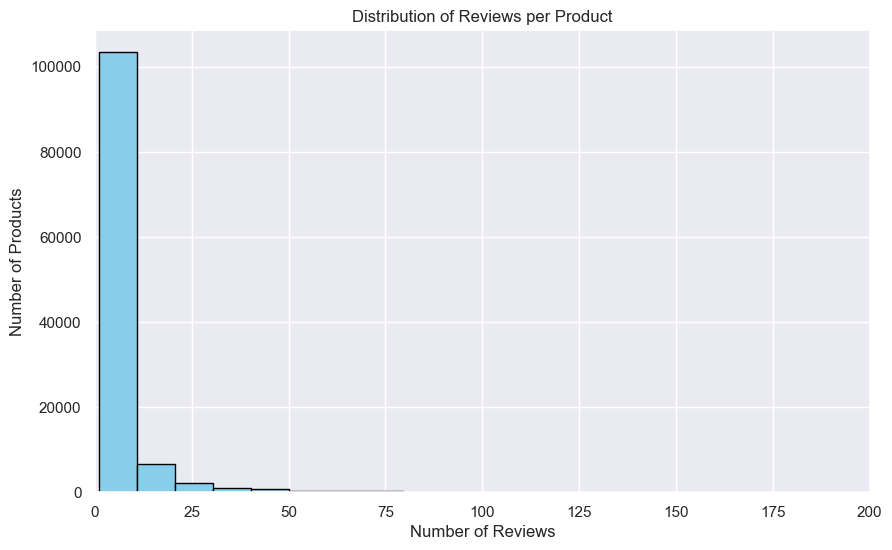

In [13]:
data['asin'] = data['asin'].astype(str)
reviews_per_product = data.groupby('asin').size()

plt.figure(figsize=(10, 6))
plt.hist(reviews_per_product, bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Products')
plt.xlim(0, 200)
plt.grid(True)
plt.show()

#### NaN / Empty entries

Let's check for NaNs or empty entries and remove the entries.

Note: I will discard all columns except for "rating" (target) and "text" (input) as the goal is to predict the product score just from the review text.

In [15]:
data = data[["rating", "text"]]
print(f"#NaN entires: {data.isna().sum()} \n#empty entries: {data['text'].str.strip().eq('').sum()}")

#NaN entires: rating    0
text      0
dtype: int64 
#empty entries: 720


We see that there are no NaN values, but 720 empty text entries. We will exclude those as they are not helpful to predict a product score.

In [16]:
#Let's drop the empty entries
print(len(data))
data = data[~data["text"].str.strip().eq('')].reset_index(drop=True)
print(len(data))

701528
700808


## 2. Data Preparation

Split data into train, validation, and test sets (80/10/10)

c:\Users\s_gue\anaconda3\envs\ml_basics\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\s_gue\anaconda3\envs\ml_basics\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\s_gue\anaconda3\envs\ml_basics\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\s_gue\anaconda3\envs\ml_basics\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

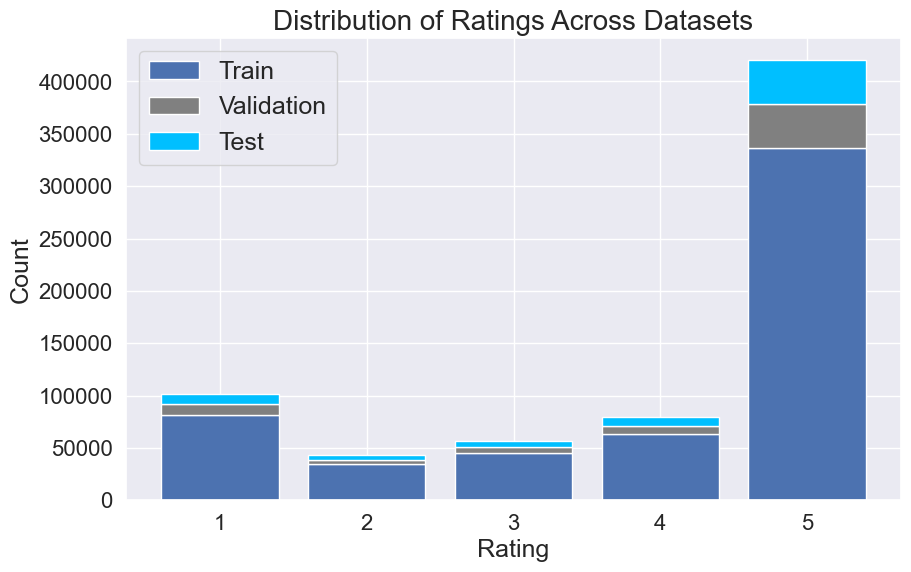

In [17]:
#Split into train, validation, and test sets (note: we stratify by target)
train_data, temp_data = train_test_split(data, train_size=0.8, stratify=data.rating, shuffle=True, random_state=SEED)
val_data, test_data = train_test_split(temp_data, train_size=0.5, stratify=temp_data.rating)

#Reset index for each split
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

#Save to disk for re-use
train_data.to_csv("../datasets/Amazon_Beauty/train.csv", index=False)
val_data.to_csv("../datasets/Amazon_Beauty/val.csv", index=False)
test_data.to_csv("../datasets/Amazon_Beauty/test.csv", index=False)

#Sanity check target distributions:
#Calculate target class counts for each split
train_counts = train_data.rating.value_counts()
val_counts = val_data.rating.value_counts()
test_counts = test_data.rating.value_counts()

#Plot stacked target distributions across datasets
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(train_counts.index, train_counts, label="Train")
ax.bar(val_counts.index, val_counts, bottom=train_counts, label="Validation", color="grey")
ax.bar(test_counts.index, test_counts, bottom=train_counts + val_counts, label="Test", color="deepskyblue")
ax.set_xlabel("Rating", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Distribution of Ratings Across Datasets", fontsize=20)
ax.set_xticks(range(1, 6))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16) 
ax.legend(fontsize=18) 
plt.show()

#### Problem: Sequence Length
Then, we check what the common sequence length after tokenization is and whether we need to adapt sequence lengths.

Possible solutions:
- Truncate sequences: If there are only few cases that exceed the expected sequence length (512), we may just truncate them
- Filter out filler words (like "a", "the",...) to shorten sequences at the expense of creating a stronger distribution shift for the pretrained model

As only 0.17% of samples go beyond this maximum sequence length, we will truncate those sentences.

Max length: 3604
Avg length: 43.09659849773404
Percentage of sequences exceeding 512 tokens: 0.17%


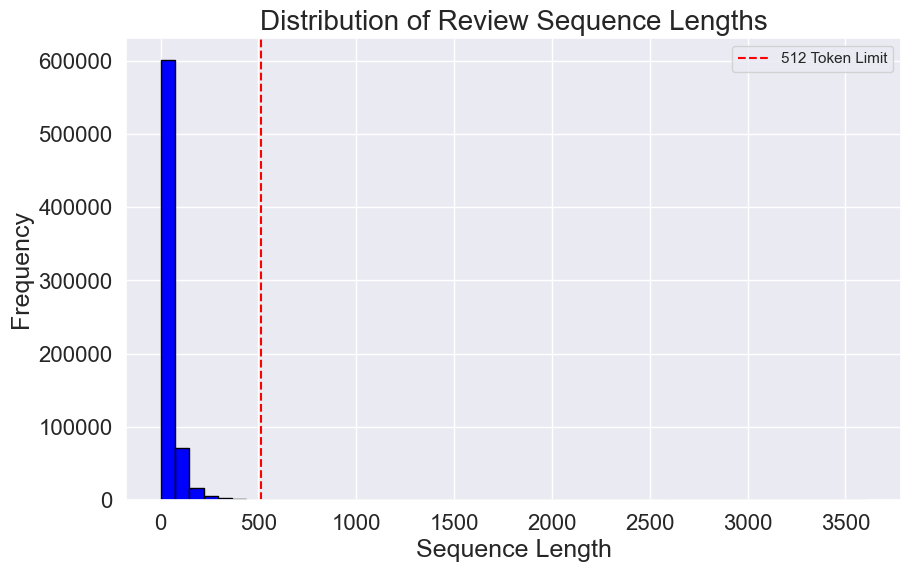

In [18]:
#Get sequence lengths
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
seq_lengths = []
for i in range(len(data)):
    seq_lengths.append(len(tokenizer(data.text[i], return_tensors='pt')['input_ids'][0]))

print(f"Max length: {max(seq_lengths)}")
print(f"Avg length: {np.mean(seq_lengths)}")

#Get % of sequences that exceed the 512 token limit
num_long_sequences = sum([1 for length in seq_lengths if length > 512])
percentage_long_sequences = (num_long_sequences / len(seq_lengths)) * 100
print(f"Percentage of sequences exceeding 512 tokens: {percentage_long_sequences:.2f}%")

plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50, color="blue", edgecolor="black")
plt.axvline(x=512, color="red", linestyle="--", label="512 Token Limit")
plt.xlabel("Sequence Length", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Distribution of Review Sequence Lengths", fontsize=20)
plt.legend()
plt.show()

## 3. Dataset and Dataloading

Let's first create a dataset class for our datasets.

In [28]:
class BeautyDataset(Dataset):
    def __init__(self, dataset_path: Path, tokenizer: AutoTokenizer, max_length: int = 512):
        self.data = pd.read_csv(dataset_path)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        encoding = self.tokenizer.encode_plus(
            self.data.text[index],
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label = torch.tensor(self.data.rating[index] - 1, dtype=torch.long) #zero-based index

        return {"input_ids": input_ids.squeeze(), "attention_mask": attention_mask.squeeze()}, label

#### Load datasets

We will use a pretrained RoBERTa model, Tokenizer and Config from HuggingFace.

In [29]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

#Set up datasets
training_data = BeautyDataset(Path("../datasets/Amazon_Beauty/train.csv"), tokenizer)
val_data = BeautyDataset(Path("../datasets/Amazon_Beauty/val.csv"), tokenizer)
test_data = BeautyDataset(Path("../datasets/Amazon_Beauty/test.csv"), tokenizer)

#Set up dataloaders
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8)

## 4. Training

I will load a pretrained RoBERTa model used for sentiment analysis on Twitter tweets. Initially, I adapted its classifier head to map to 5 outputs for classification.
However, this neglected the fact that some errors are worse than others (e.g. predicting a rating of 1 instead of 5 vs. predicting a 4 instead of a 5).
Therefore, I will treat it as a regression problem by mapping to one regression output and using MAE loss. The pretrained model is finetuned for 3 epochs.

System constraints: I am running this fine on a RTX 3070 Laptop GPU with 8GB using Mixed Precision training and a rather low batch size of 8.
There would be ways to further reduce memory consumption at the cost of speed:
- reducing batch size
- gradient accumulation
- activation checkpointing
- switching optimizer to SGD + scheduler (Adam maintains first- & second-order moments for each parameter --> memory overhead)

Note: I have left the metrics for the classification task in, in case you would like to discuss those.

In [ ]:
#Load pretrained model
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

#model.classifier.out_proj = nn.Linear(in_features=768, out_features=5, bias=True) #classification
model.classifier.out_proj = nn.Linear(in_features=768, out_features=1, bias=True) #regression

#Freeze everything except for the classifier head 
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.classifier.parameters():
#     param.requires_grad = True

#Load finetuned model
#model.load_state_dict(torch.load("./fine_tuned_roberta_large_epoch3.pth"))

wandb.init(project='sentiment_analysis', entity='thatsvenyouknow')
model = model.to(DEVICE)
#criterion = nn.CrossEntropyLoss() #classification
criterion = nn.L1Loss() #regression
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#Initialize Mixed Precision Gradient Scaler
scaler = GradScaler()

num_epochs = 10
for epoch in range(num_epochs):

    #Training
    train_loss = 0.0
    train_predictions = []
    train_true_labels = []

    model.train()
    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        input_ids, attention_mask, labels = inputs['input_ids'].to(DEVICE), inputs['attention_mask'].to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        #Forward 
        with autocast():
            outputs = model(input_ids = input_ids, attention_mask = attention_mask).logits.squeeze()
            loss = criterion(outputs, labels.long())

        #Backward and optimize
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #predicted = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
        predicted = np.clip(np.round(outputs.detach().cpu().numpy()), 0, 4).astype(int) #round to nearest integer and clip to [0, 4]
        train_loss += loss.item()
        train_predictions.extend(predicted) #.cpu().numpy()
        train_true_labels.extend(labels.cpu().numpy())

    train_f1_score = f1_score(train_true_labels, train_predictions, average='weighted') #
    train_accuracy = accuracy_score(train_true_labels, train_predictions) * 100

    #Validation
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_true_labels = []

    with torch.inference_mode():
        for inputs, labels in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            input_ids, attention_mask, labels = inputs['input_ids'].to(DEVICE), inputs['attention_mask'].to(DEVICE), labels.to(DEVICE)
            
            with autocast():
                outputs = model(input_ids = input_ids, attention_mask = attention_mask).logits.squeeze()
                loss = criterion(outputs, labels.long())
                
            #predicted = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
            predicted = np.clip(np.round(outputs.detach().cpu().numpy()), 0, 4).astype(int) #round to nearest integer and clip to [0, 4]
            val_loss += loss.item()
            val_predictions.extend(predicted) #.cpu().numpy()
            val_true_labels.extend(labels.cpu().numpy())

        val_f1_score = f1_score(val_true_labels, val_predictions, average="weighted")
        val_accuracy = accuracy_score(val_true_labels, val_predictions) * 100

    print(f"Epoch {epoch+1}")
    print(f"[Train] Loss: {train_loss/len(train_dataloader):.3f}, Accuracy: {train_accuracy:.3f}, F1 Score: {train_f1_score:.3f}") 
    print(f"[Val] Loss: {val_loss/len(val_dataloader):.3f}, Accuracy: {val_accuracy:.3f}, F1 Score: {val_f1_score:.3f}")
    wandb.log({"train_loss": train_loss / len(train_dataloader), "train_accuracy": train_accuracy, "train_f1_score": train_f1_score})
    wandb.log({"val_loss": val_loss / len(val_dataloader), "val_accuracy": val_accuracy, "val_f1_score": val_f1_score})

    torch.save(model.state_dict(), f"./fine_tuned_roberta_large_epoch{epoch+1}.pth")

wandb.finish()

In [7]:
#Save the model
torch.save(model.state_dict(), "./fine_tuned_roberta_final.pth")

## 5. Testing

The trained model should only be used once on the test set to avoid data leakage. Below, we can see the overall and the class specific results.

Note: Next to our primary outcome objective, the MAE loss, I also categorized the regression output to match to the different classes as a classification estimate. The F1 score is used as it better accounts for the class imbalance in the data.

In [31]:
#Test
model.eval()
test_loss = 0.0
test_predictions = []
test_true_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc=f"Testing"):
        input_ids, attention_mask, labels = inputs['input_ids'].to(DEVICE), inputs['attention_mask'].to(DEVICE), labels.to(DEVICE)
        
        outputs = model(input_ids = input_ids, attention_mask = attention_mask).logits.squeeze()
        loss = criterion(outputs, labels.long())
        test_loss += loss.item()
        #predicted = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
        predicted = np.clip(np.round(outputs.detach().cpu().numpy()), 0, 4).astype(int)
        test_predictions.extend(predicted)
        test_true_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_true_labels, test_predictions) * 100
    test_f1_score = f1_score(test_true_labels, test_predictions, average="weighted")

print(f"[Test] Loss: {test_loss/len(test_dataloader):.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1_score:.3f}") 

Testing: 100%|██████████| 8759/8759 [25:53<00:00,  5.64it/s]  


[Test] Loss: 0.303, Accuracy: 77.371, F1 Score: 0.761


Let's check the per class metrics

In [32]:
def per_class_mae(y_true: np.array, y_pred: np.array):
    """
    Calculate and print per-class Mean Absolute Error (MAE).
    - MAE for each class: Average absolute error for the predictions corresponding to each true class label.

    Parameters:
    - y_true: array-like of shape (n_samples,)
        True labels for the data.
    - y_pred: array-like of shape (n_samples,)
        Predicted labels for the data.
    """
    label = [0, 1, 2, 3, 4]
    per_class_mae = np.zeros(5)

    for i in label:
        # Select indices for the current class
        indices = (y_true == i)
        
        # Extract true and predicted values for the current class
        y_true_class = y_true[indices]
        y_pred_class = y_pred[indices]
        
        # Compute MAE for the current class
        if len(y_true_class) > 0:  # Check to avoid division by zero if there are no samples for a class
            mae = np.mean(np.abs(y_true_class - y_pred_class))
        else:
            mae = 0  # Alternatively, you could use NaN or skip printing this class
        
        per_class_mae[i] = mae

    # Print the results
    for i in label:
        print(f"Class {i+1}:")
        print(f"  MAE: {per_class_mae[i]:.2f}")

We can see that the extreme cases (1 or 5) are much easier to predict. Additionally, the predictions for 5 ratings is superior to the other ones which is not surprising given the target distribution.

In [33]:
per_class_mae(np.array(test_true_labels), np.array(test_predictions))

Class 1:
  MAE: 0.31
Class 2:
  MAE: 0.83
Class 3:
  MAE: 0.80
Class 4:
  MAE: 0.72
Class 5:
  MAE: 0.08


In [34]:
def per_class_metrics(y_true: np.array, y_pred: np.array):
    """
    Calculate and print per-class accuracy and precision.
    - Precision: Out of all examples that were predicted as class i, how many were actually class i?
    - Recall: Out of all examples that are actually class i, how many were predicted as class i?
    
    Parameters:
    - y_true: array-like of shape (n_samples,)
        True labels for the data.
    - y_pred: array-like of shape (n_samples,)
        Predicted labels for the data.


    """
    #Initialize arrays for storing the metrics
    per_class_precision = np.zeros(5)
    per_class_recall = np.zeros(5)
    
    label = [0, 1, 2, 3, 4]

    for i in label:
        #Create binary labels for the current class
        y_true_bin = (y_true == i)
        y_pred_bin = (y_pred == i)
        
        #Calculate precision, recall and accuracy for the current class
        per_class_precision[i] = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        per_class_recall[i] = recall_score(y_true_bin, y_pred_bin, zero_division=0)

    # Print the results
    for i in label:
        print(f"Class {i+1}:")
        print(f"  Precision: {per_class_precision[i]:.2f}")
        print(f"  Recall: {per_class_recall[i]:.2f}")

In [35]:
per_class_metrics(np.array(test_true_labels), np.array(test_predictions))

Class 1:
  Precision: 0.73
  Recall: 0.81
Class 2:
  Precision: 0.33
  Recall: 0.26
Class 3:
  Precision: 0.45
  Recall: 0.42
Class 4:
  Precision: 0.48
  Recall: 0.34
Class 5:
  Precision: 0.89
  Recall: 0.95


## 6. Visualization of Feature Importance

To visualize which words in a review were important for the prediction, I will calculate the gradients with respect to the input.

Alternative ways:
- Attention Rollout: We could also look at the attention maps to visualize feature importance (unfortunately, this particular model does not give out the attention weights without tweaking it)
- Using one of the open-source libraries: Lime, Captum, ...

In [38]:
def visualize_feature_importance(
        data_path: Path = Path("../datasets/Amazon_Beauty/test.csv"), 
        model_path = Path("./fine_tuned_roberta_final.pth"),
        below_rating: int = 2, 
        above_rating: int = 4, 
        n_samples: int = 5,
        max_length: int = 30,
        seed: int = 42
        ):
    data = pd.read_csv(data_path)

    #Initialize finetuned model
    MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    model.classifier.out_proj = nn.Linear(in_features=768, out_features=1, bias=True)
    model.load_state_dict(torch.load(model_path))
    model = model.to(DEVICE)
    model.train()
    criterion = nn.L1Loss()

    #Create hook to capture embeddings and register to embedding layer
    def capture_embeddings(module, input, output):
        global embeddings
        embeddings = output
        embeddings.retain_grad() 

    hook = model.roberta.embeddings.register_forward_hook(capture_embeddings)

    #Filter out sentences with length > max_length
    data['word_count'] = data['text'].apply(lambda x: len(x.split()))
    data = data[data['word_count'] < max_length]

    high_rating_samples = data[data['rating'] >= above_rating].sample(n=n_samples, random_state=seed)
    low_rating_samples = data[data['rating'] <= below_rating].sample(n=n_samples, random_state=seed)

    #concatenate high and low rating samples
    samples = pd.concat([high_rating_samples, low_rating_samples])
    results = []

    for idx, row in samples.iterrows():    
        coloring = "0, 128, 0" if row['rating'] >= above_rating else "128, 0, 0"
        input_text = row['text']
        inputs = tokenizer(input_text, return_tensors="pt").to(DEVICE)
        output = model(**inputs).logits.squeeze()
        label = torch.tensor([row['rating'] - 1], dtype=torch.float).to(DEVICE)
        loss = criterion(output, label)
        loss.backward()

        tokens = tokenizer.tokenize(input_text)
        tokens = [token.replace("Ġ", "") if token.startswith("Ġ") else token for token in tokens]
        grads = embeddings.grad #Grab gradients
        word_importance = torch.norm(grads, dim=2).squeeze() #Compute L2 norm across embedding dimensions
        word_importance = (word_importance / torch.max(word_importance))#**2 #Normalize and square to enhance differences
        tokens = ['[CLS]'] + tokens + ['[SEP]']  #Adding special tokens to match the number of tokens
        
        html_string = "<p style='font-size:16px'>"
        for word, score in zip(tokens, word_importance):
            if word != "[CLS]" and word != "[SEP]":  #Skip the CLS and SEP tokens for output
                alpha = score  #Use importance score as opacity
                html_string += f"<span style='background-color:rgba({coloring},{alpha:.2f})'>{word} </span>"
        html_string += "</p>"

        #Store results
        results.append({'True Label': int(label.item())+1, 'Predicted Label': round(output.item() + 1,2), 'Highlighted Review': html_string})
        embeddings.grad.zero_() #Reset gradients

    #Cleanup: remove the hook
    hook.remove()

    #Create DataFrame from results
    results_df = pd.DataFrame(results)

    #Adjust styling
    def styled_df(df):
        return df.style.format({
            'Predicted Label': "{:.2f}"
            }).set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt')]},
            {'selector': 'th', 'props': [('text-align', 'center')]},
            {'selector': 'td:nth-child(1), td:nth-child(2)', 'props': [('width', '40px')]},
            {'selector': 'td:nth-child(3)', 'props': [('width', '400px')]},
        ])
    
    return styled_df(results_df)

visualize_feature_importance(below_rating = 1, above_rating = 5)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
c:\Users\s_gue\anaconda3\envs\ml_basics\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the 

,True Label,Predicted Label,Highlighted Review
0,5,4.97,"Very com fy , looks good on , love the fit with the mask ."
1,5,4.98,"Great comb , just be prepared to get either purple , black or gray . I got two of each in my 6 - pack ."
2,5,4.90,Ex cel ente
3,5,4.90,Yes thank you for delivering my fragrance fast ! Sm ells great : )
4,5,5.00,Great value
5,1,1.01,Sc im py and difficult to use . Do not recommend .
6,1,1.01,It came early wore it for the first time today it doesn 't curl or hold a curl also tang les and sheds alot . Bad purchase I wouldn 't recommend . Java Ellis
7,1,1.02,This product is not for regular use . if you have a build up then you need professional help to get to were you cab maintain your call us .
8,1,1.00,Never used again after first try
9,1,1.01,Very Cheap quality
